## 🎙️ Introduction
The objective of this notebook is to gain a rough overview of the data that we may want to work with during the [competition](https://www.kaggle.com/competitions/llm-detect-ai-generated-text/overview). We compare the original train essays (handwritten by students) with the Gemini Pro-generated essays. The outcome should help us generate ideas regarding the terms in which we need to transform the data. It's important to note that I took care to ensure that the generated data was as generic as possible to have all possible cards in our hands.

- I refer to my [GEMINI PRO LLM DAIGT Dataset](https://www.kaggle.com/datasets/etiennekaiser/gemini-pro-llm-daigt-dataset)
- and to the [Original Train Dataset](https://www.kaggle.com/competitions/llm-detect-ai-generated-text/data?select=train_essays.csv)

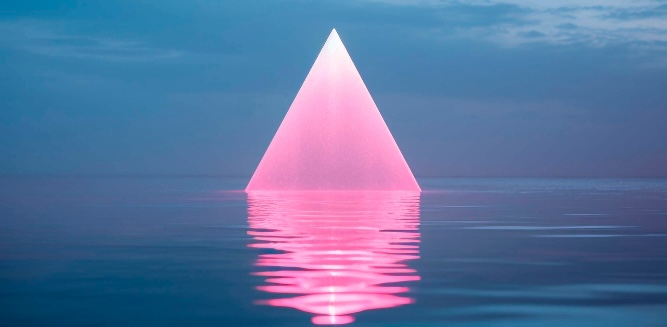

## 📡 Imports
First we import our libraries and data we want to explore.

In [1]:
pip install prettytable

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from prettytable import PrettyTable
from sklearn.feature_extraction.text import CountVectorizer
import re, string
from collections import Counter

In [3]:
original_train = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')
gemini_pro_train = pd.read_csv('/kaggle/input/gemini-pro-llm-daigt-dataset/train_essays_v1.csv')

Define a bunch of colors, the eye is coding as well ;)

In [4]:
colors = ['#FF92FF', '#E68FF2', '#CE8CE6', '#B58AD9', '#9C87CC', '#8484C0', '#6B81B3']

## 🔍 Overview
Let's begin with diving into the data! 

In [5]:
original_train.head(4)

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0


In [6]:
gemini_pro_train.head(4)

,text,label,prompt_name,source,RDizzl3_seven
0,The Electoral College is a complex system that...,1,Does the electoral college work?,gemini_pro,True
1,"The exploration of Venus, Earth's closest plan...",1,Exploring Venus,gemini_pro,True
2,## Does the Electoral College Work?\n\nThe Ele...,1,Does the electoral college work?,gemini_pro,True
3,"In the vast realm of literature, there exists ...",1,"""A Cowboy Who Rode the Waves""",gemini_pro,True


In [7]:
original_train.shape

(1378, 4)

In [8]:
gemini_pro_train.shape

(3500, 5)

Quick check if NaN's exist in our dataframes:

In [9]:
original_train.isna().sum()

id           0
prompt_id    0
text         0
generated    0
dtype: int64

In [10]:
gemini_pro_train.isna().sum()

text             0
label            0
prompt_name      0
source           0
RDizzl3_seven    0
dtype: int64

We take a look at the amount of data that is whether generated or not.

In [11]:
original_train['generated'].value_counts()

generated
0    1375
1       3
Name: count, dtype: int64

Next we remove the above 3 rows that are llm generated (1) on the original train essay to only keep the handwritten student essays (0).

In [12]:
original_train.drop(original_train[original_train['generated'] == 1].index, inplace=True)

Beside the 1375 handwritten essays (0) we have also the 3500 llm generated (0) essays which we are comparing down below.

In [13]:
gemini_pro_train['label'].value_counts()

label
1    3500
Name: count, dtype: int64

## 📝 Prompts (Type and Amount)
The 2 prompts that the competition provided us in the train_essay.csv is labeled as integer:
- 0 - **Car-free cities**
- 1 - **Does the electoral college work?**

In addition to that my generated essays is based on following 7 prompts:
- **Does the electoral college work?**
- **Exploring Venus**
- **"A Cowboy Who Rode the Waves"**
- **Driverless cars**
- **The Face on Mars**
- **Car-free cities**
- **Facial action coding system**

In [14]:
original_train['prompt_id'].value_counts()

prompt_id
0    707
1    668
Name: count, dtype: int64

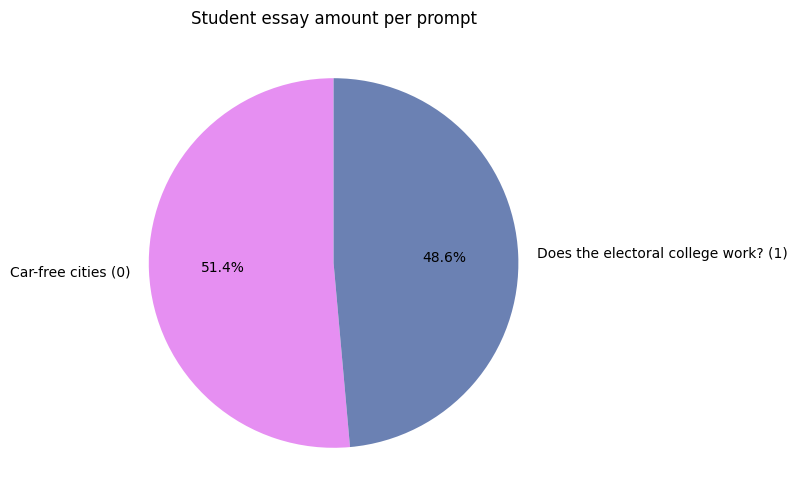

In [15]:
ot_prompt_counts = original_train['prompt_id'].value_counts()
pie_colors = [colors[1], colors[6]]

plt.figure(figsize=(6, 6))
plt.pie(ot_prompt_counts, labels=['Car-free cities (0)', 'Does the electoral college work? (1)'], 
        colors=pie_colors, 
        autopct='%1.1f%%', 
        startangle=90)
plt.title('Student essay amount per prompt', fontsize=12)
plt.show()

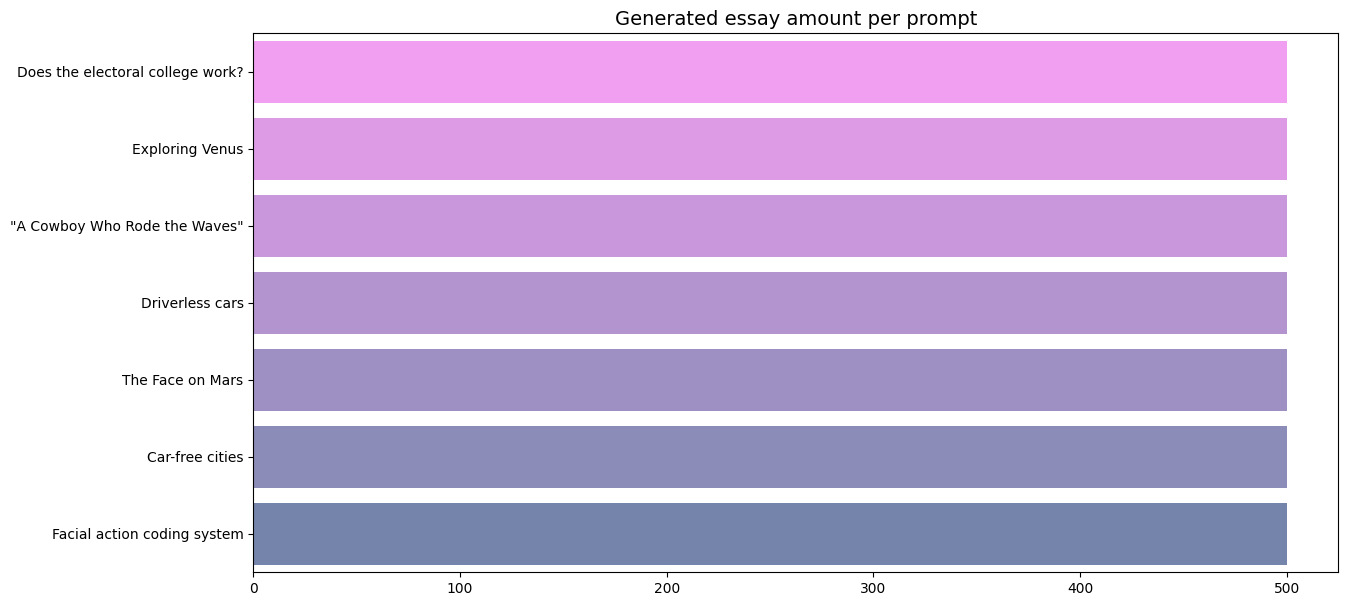

In [16]:
gpt_prompt_counts = gemini_pro_train['prompt_name'].value_counts()

plt.figure(figsize=(14, 7))
sns.barplot(x=gpt_prompt_counts.values, y=gpt_prompt_counts.index, palette=colors)
plt.title('Generated essay amount per prompt', fontsize=14)
plt.ylabel('')
plt.show()

## 📐 General: Text Length
The below graphs give us insights about the distribution of the amount of characters, words and sentences.
During generation with Gemini Pro I defined the number of words of each essay to be that same as the average of the student essays to have a good measure of future comparisons.

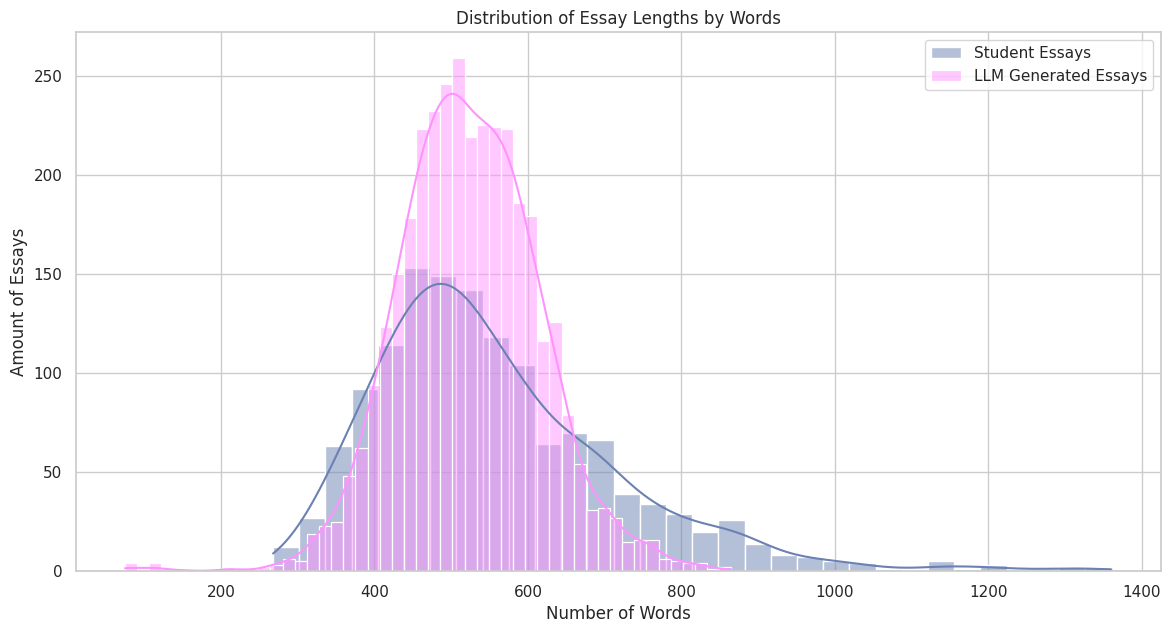

In [17]:
sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))

original_train_word_count = original_train['text'].apply(lambda x: len(x.split()))
gemini_pro_train_word_count = gemini_pro_train['text'].apply(lambda x: len(x.split()))

sns.histplot(original_train_word_count, color=colors[6], label='Student Essays', kde=True)
sns.histplot(gemini_pro_train_word_count, color=colors[0], label='LLM Generated Essays', kde=True)

plt.title('Distribution of Essay Lengths by Words')
plt.xlabel('Number of Words')
plt.ylabel('Amount of Essays')
plt.legend()
plt.show()

Followed by a plot that shows the distribution of characters:

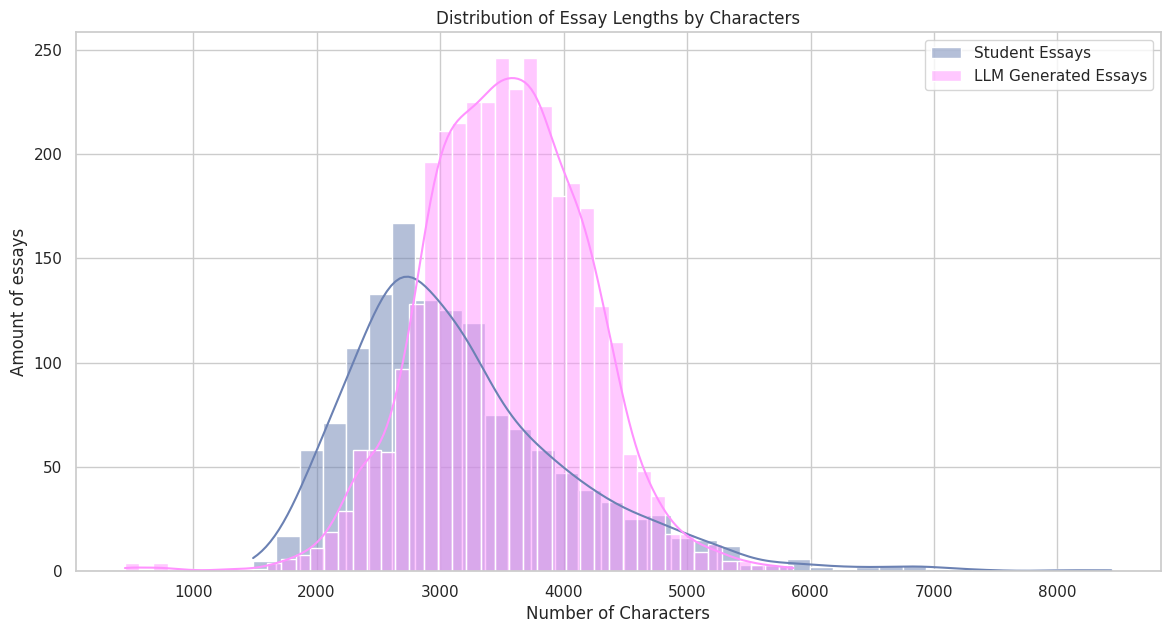

In [18]:
sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))

sns.histplot(original_train['text'].apply(len), color=colors[6], label='Student Essays', kde=True)
sns.histplot(gemini_pro_train['text'].apply(len), color=colors[0], label='LLM Generated Essays', kde=True)

plt.title('Distribution of Essay Lengths by Characters')
plt.xlabel('Number of Characters')
plt.ylabel('Amount of essays')
plt.legend()
plt.show()

Next we calculate the average for characters, words and sentences across all respective essays. First we tokenize the text and define helper functions to process the values later on in our diagrams:

In [19]:
original_train['character_count'] = original_train['text'].apply(len)
original_train['word_count'] = original_train['text'].apply(lambda x: len(word_tokenize(x)))
original_train['sentence_count'] = original_train['text'].apply(lambda x: len(sent_tokenize(x)))

original_train_average_character_counts = original_train.groupby('prompt_id')['character_count'].mean().reset_index()
original_train_average_word_counts = original_train.groupby('prompt_id')['word_count'].mean().reset_index()
original_train_average_sentence_counts = original_train.groupby('prompt_id')['sentence_count'].mean().reset_index()

In [20]:
gemini_pro_train['character_count'] = gemini_pro_train['text'].apply(len)
gemini_pro_train['word_count'] = gemini_pro_train['text'].apply(lambda x: len(word_tokenize(x)))
gemini_pro_train['sentence_count'] = gemini_pro_train['text'].apply(lambda x: len(sent_tokenize(x)))

gemini_pro_average_character_counts = gemini_pro_train.groupby('prompt_name')['character_count'].mean().reset_index()
gemini_pro_average_word_counts = gemini_pro_train.groupby('prompt_name')['word_count'].mean().reset_index()
gemini_pro_average_sentence_counts = gemini_pro_train.groupby('prompt_name')['sentence_count'].mean().reset_index()

In [21]:
def average_count_by_prompt(ax):
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [22]:
def annotate_bar(ax, data, label_mapping, title):
    ax.bar(data.index.map(label_mapping), data, color=pie_colors)
    ax.set_title(title, fontsize=14)
    average_count_by_prompt(ax)

In [23]:
average_values = pd.DataFrame({
    'Data Source': ['Original Train', 'Gemini Pro Train'],
    'Average Characters': [round(original_train['character_count'].mean(), 2), round(gemini_pro_train['character_count'].mean(), 2)],
    'Average Words': [round(original_train['word_count'].mean(), 2), round(gemini_pro_train['word_count'].mean(), 2)],
    'Average Sentences': [round(original_train['sentence_count'].mean(), 2), round(gemini_pro_train['sentence_count'].mean(), 2)]
})

table = PrettyTable()
table.field_names = average_values.columns.tolist()

for _, row in average_values.iterrows():
    table.add_row(row.tolist())

print(table)

+------------------+--------------------+---------------+-------------------+
|   Data Source    | Average Characters | Average Words | Average Sentences |
+------------------+--------------------+---------------+-------------------+
|  Original Train  |      3172.58       |     622.44    |       27.66       |
| Gemini Pro Train |      3530.06       |     591.13    |       24.58       |
+------------------+--------------------+---------------+-------------------+


## 🖊️ Prompts: Text Length
After examine the general text length we want to dive deeper into the statistics of each text written by the respective prompt of the student essays first.

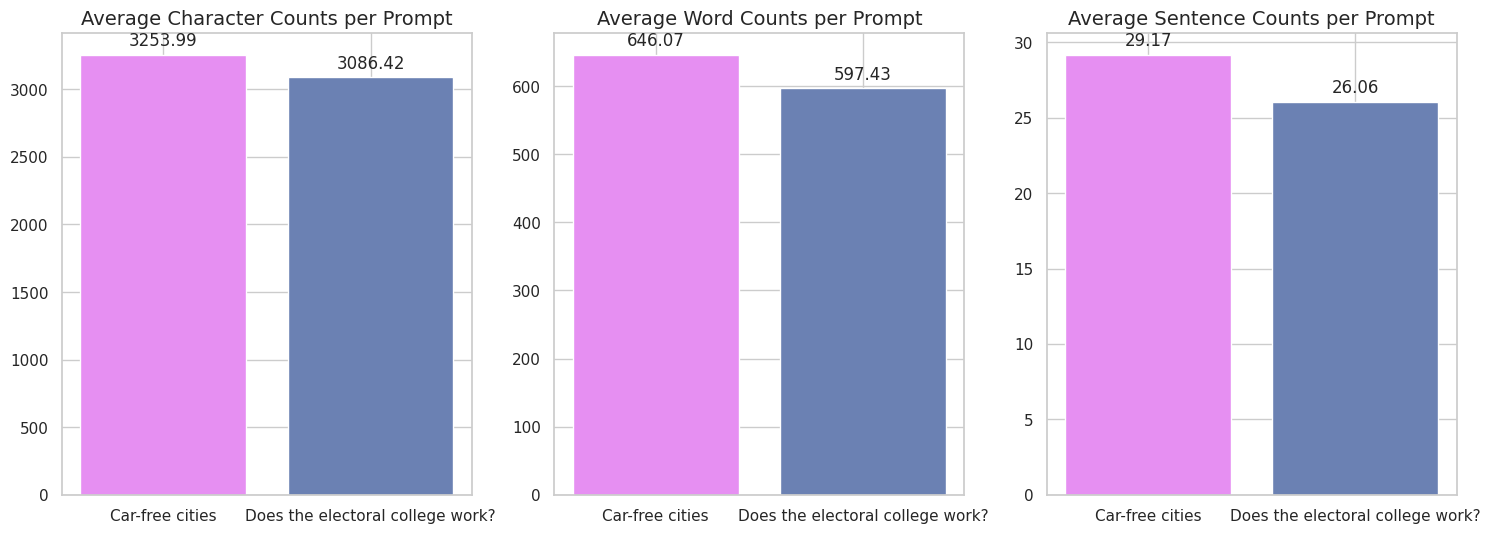

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
label_mapping = {0: 'Car-free cities', 1: 'Does the electoral college work?'}

annotate_bar(axes[0], original_train_average_character_counts['character_count'], label_mapping, 'Average Character Counts per Prompt')
annotate_bar(axes[1], original_train_average_word_counts['word_count'], label_mapping, 'Average Word Counts per Prompt')
annotate_bar(axes[2], original_train_average_sentence_counts['sentence_count'], label_mapping, 'Average Sentence Counts per Prompt')

plt.show()

Now we take a look at the characters, words and sentences average of the generated essays:

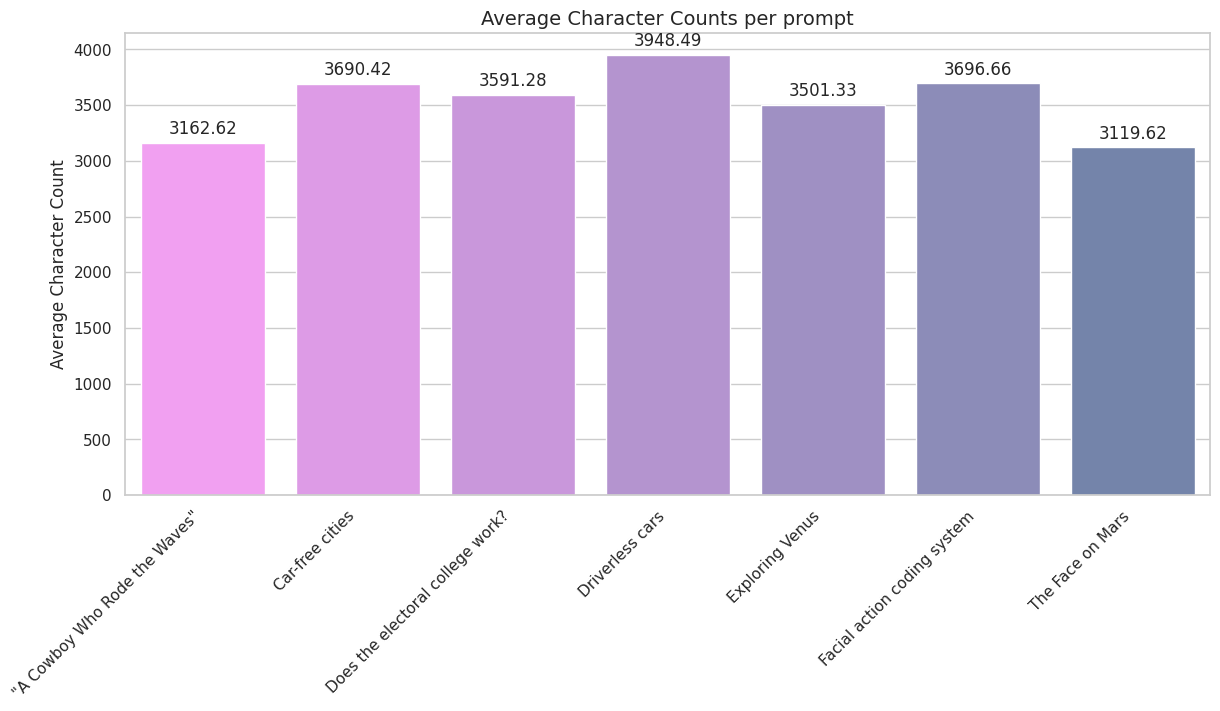

In [25]:
plt.figure(figsize=(14, 6))
ax = sns.barplot(x='prompt_name', y='character_count', data=gemini_pro_average_character_counts, palette=colors)
plt.title('Average Character Counts per prompt', fontsize=14)
plt.xlabel('')
plt.ylabel('Average Character Count')
plt.xticks(rotation=45, ha='right')
average_count_by_prompt(ax)
plt.show()

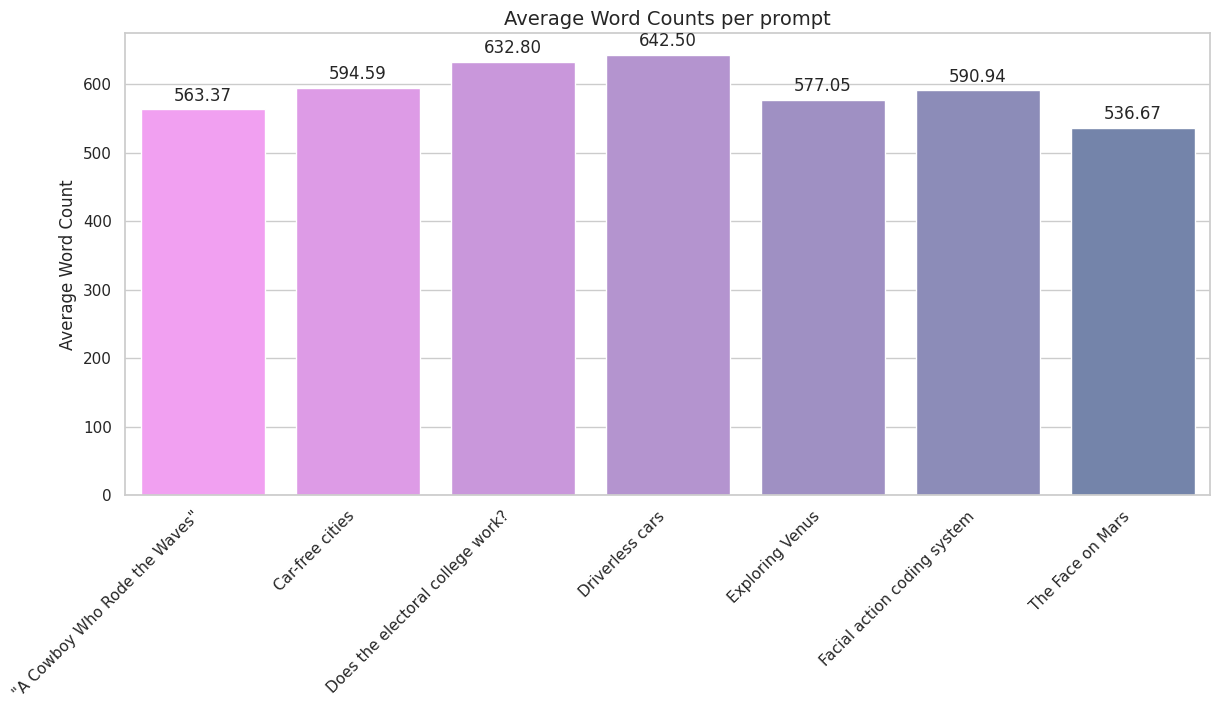

In [26]:
plt.figure(figsize=(14, 6))
ax = sns.barplot(x='prompt_name', y='word_count', data=gemini_pro_average_word_counts, palette=colors)
plt.title('Average Word Counts per prompt', fontsize=14)
plt.xlabel('')
plt.ylabel('Average Word Count')
plt.xticks(rotation=45, ha='right')
average_count_by_prompt(ax)
plt.show()

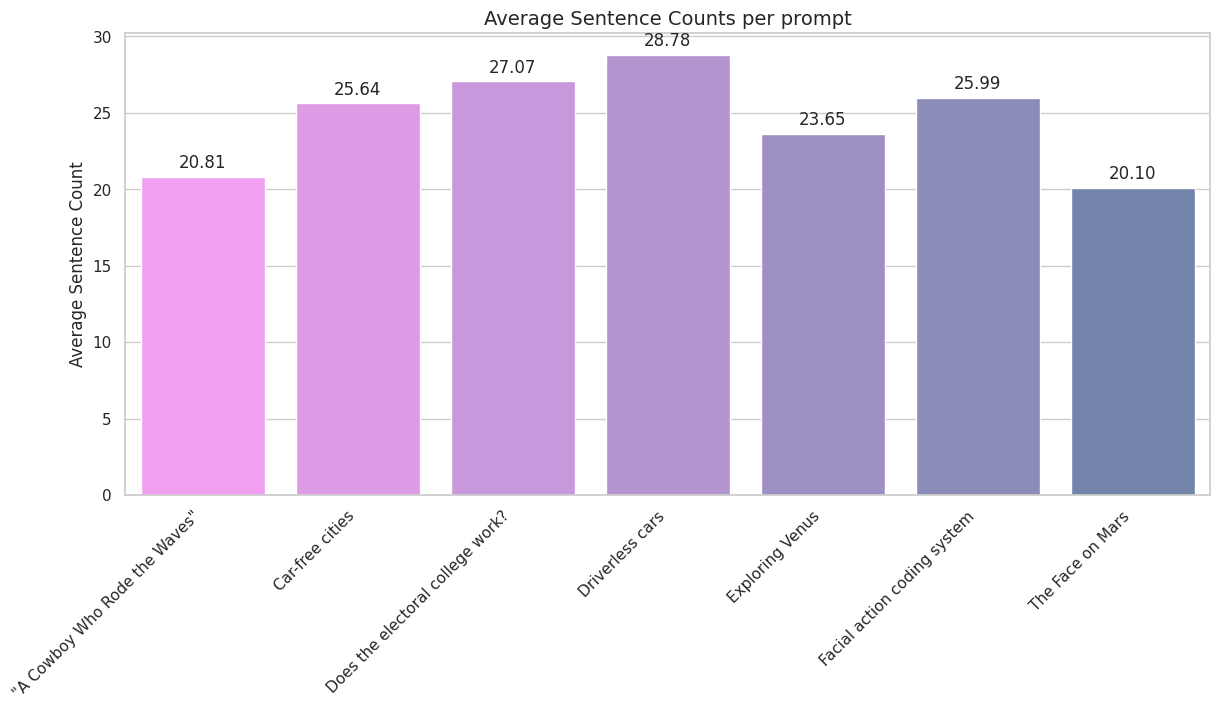

In [27]:
plt.figure(figsize=(14, 6))
ax = sns.barplot(x='prompt_name', y='sentence_count', data=gemini_pro_average_sentence_counts, palette=colors)
plt.title('Average Sentence Counts per prompt', fontsize=14)
plt.xlabel('')
plt.ylabel('Average Sentence Count')
plt.xticks(rotation=45, ha='right')
average_count_by_prompt(ax)
plt.show()

## 📚 Common words
Now we compare the 20 most frequent words in both essay types.

In [28]:
def common_words(data, n=20):
    vectorizer = CountVectorizer(stop_words=stopwords.words('english'))
    word_matrix = vectorizer.fit_transform(data['text'])
    word_freq = pd.DataFrame(word_matrix.sum(axis=0), columns=vectorizer.get_feature_names_out())
    common_words = word_freq.transpose().sort_values(by=0, ascending=False).head(n)
    return common_words

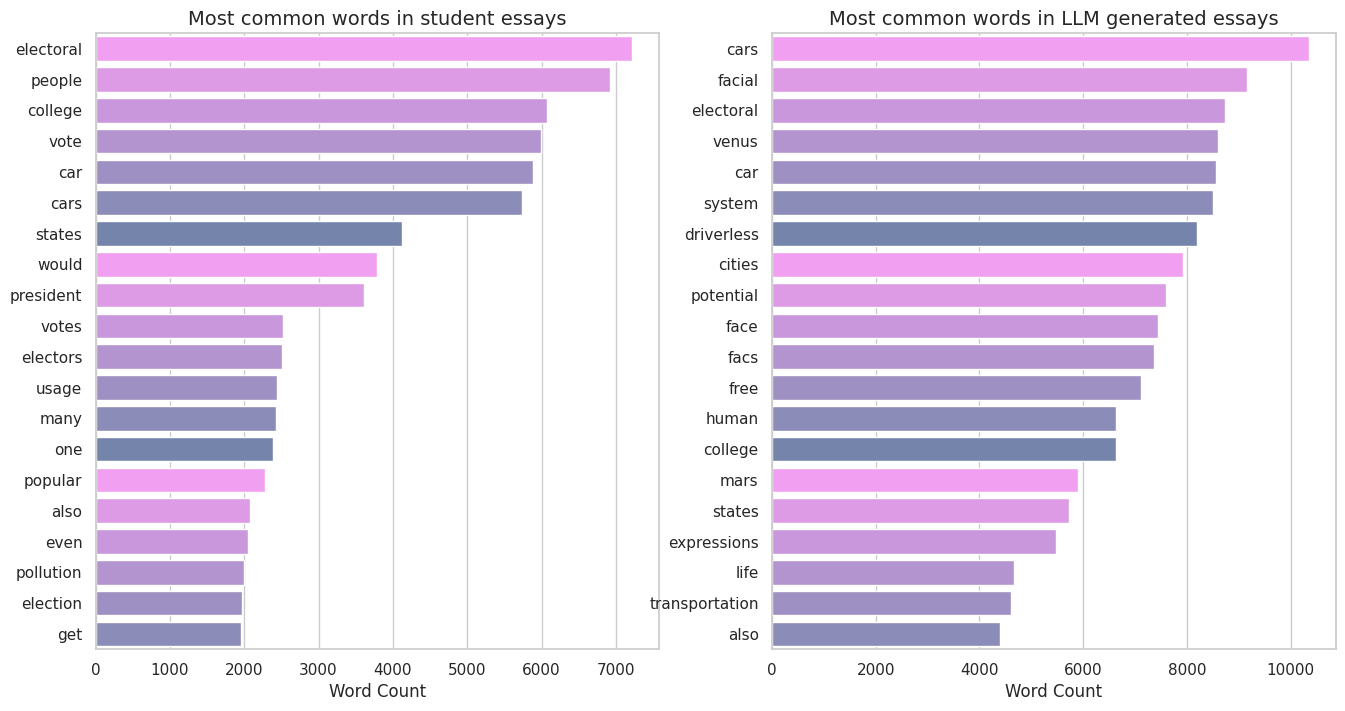

In [29]:
original_train_common_words = common_words(original_train)
gemini_pro_train_common_words = common_words(gemini_pro_train)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
sns.barplot(x=original_train_common_words[0], y=original_train_common_words.index, palette=colors)
plt.title('Most common words in student essays', fontsize=14)
plt.xlabel('Word Count')
plt.ylabel('')

plt.subplot(1, 2, 2)
sns.barplot(x=gemini_pro_train_common_words[0], y=gemini_pro_train_common_words.index, palette=colors)
plt.title('Most common words in LLM generated essays', fontsize=14)
plt.xlabel('Word Count')
plt.ylabel('')

plt.show()

## 🦄 Unique words
Let's explore how many unique words are existing in our datasets. As we can clearly see below the students are way more creative in respect to the length of texts.

In [30]:
original_train_unique_words = set(original_train['text'].str.split().explode())
gemini_pro_train_unique_words = set(gemini_pro_train['text'].str.split().explode())

table = PrettyTable(['Dataset', 'Number of Unique Words'])
table.add_row(['Student Essays', len(original_train_unique_words)])
table.add_row(['LLM Generated Essays', len(gemini_pro_train_unique_words)])

print(table)

+----------------------+------------------------+
|       Dataset        | Number of Unique Words |
+----------------------+------------------------+
|    Student Essays    |         29523          |
| LLM Generated Essays |         19764          |
+----------------------+------------------------+


## 中 Special Characters & Symbols
In this section we will have a look at the special characters which can be helpful in understanding the noise between handwritten and llm generated texts. As always let's start with the original data.

In [31]:
def generate_special_characters_table(df, text_column='text'):
    all_text = ''.join(df[text_column])
    special_characters = ''.join(c for c in all_text 
                                 if c not in string.ascii_letters 
                                 and c not in string.digits 
                                 and c not in string.whitespace)
    character_counts = Counter(special_characters)
    table = PrettyTable(['Special Character', 'Count'])

    for char, count in character_counts.items():
        table.add_row([char, count])

    table.sortby = 'Count'
    table.reversesort = True

    return table

In [32]:
print(generate_special_characters_table(original_train))

+-------------------+-------+
| Special Character | Count |
+-------------------+-------+
|         .         | 39962 |
|         ,         | 33089 |
|         "         | 10519 |
|         '         |  7116 |
|         ?         |  1452 |
|         :         |  722  |
|         !         |  493  |
|         %         |  387  |
|         &         |   17  |
|         _         |   16  |
+-------------------+-------+


Now we can take a look at the generated essays and with no surprise it has a lot of special characters. Even the notebook is getting very long, I want to print out all of them to provide us a representative view on that.

In [33]:
print(generate_special_characters_table(gemini_pro_train))

+-------------------+--------+
| Special Character | Count  |
+-------------------+--------+
|         ,         | 123296 |
|         .         | 86328  |
|         -         | 17161  |
|         '         | 10001  |
|         :         |  8742  |
|         *         |  7507  |
|         "         |  3774  |
|         )         |  1668  |
|         (         |  1668  |
|         #         |  901   |
|         ?         |  601   |
|         —         |  295   |
|         %         |  205   |
|         ;         |  136   |
|         的        |   80   |
|         ，        |   49   |
|         。        |   38   |
|         /         |   37   |
|         –         |   36   |
|         °         |   35   |
|         т         |   30   |
|         и         |   30   |
|         和        |   29   |
|         车        |   28   |
|         行        |   25   |
|         е         |   25   |
|         道        |   24   |
|         可        |   24   |
|         市        |   21   |
|         人      

## 🎓 Take-away
#### Text Statistics:

* **Handwritten Stunden Essays** (original_train with 1375 rows):
 - Average character count: 3172.58 characters
 - Average word count: 622.44 words
 - Average sentence count: 27.66 sentences
 - Average unique words: 29523 words


* **LLM Generated Essays** (gemini_pro_train with 3500 rows):
 - Average character count: 3530.06 characters
 - Average word count: 591.13 words
 - Average sentence count: 24.58 sentences
 - Average unique words: 19764 words

#### Conclusion:

- Student essays are more complex in terms of unique words per lengths, which results in higher variety of texts.
- The LLM generated essays are generally more prone to include special characters which a student wouldn't intuitively.
- The LLM generated essays tend to have longer words. This can be observed in the "characters amount" against the "words amount" histplot at the top.
- Both datasets have almost the same amount of words per essays (intentionally!)

#### What's next?

1. **Data Cleaning:** Addressing the presence of special characters, excluding those commonly used in sentences of course. 
2. **Word Grouping/Mapping:** Categorizing and mapping of the most common words could be beneficial.
3. **Data Balance Exploration:** Experimenting with the balance between existing data and additional data. Start with a small dataset to observe the impact of introducing more data, avoiding the introduction of noisy "hills" in the data.
4. **Prediction of words/sentences:** A more advanced technique is to make subpredictions on parts of texts towards your final model to get a more fine grained result.


In [34]:
# What's next? 1. Data Cleaning - You can use this to keep only relevant characters.
#train['text'].replace(r'[^\w\s!’?¨&%()´_–”*“;/:.,\'"-\[\]]', ' ', regex=True, inplace=True)

## 🤝 Final word
You made it till here! 
This is my very first notebook on my very first dataset, I appreciate any input and feedback.
I spent couple of days on it to think of a concise and fitting way to represent data properly, as there is a large pool of options to do so.

Thank you! 🙌